Mask the leading two constituents in energy, calculate the **mean** and __stderr__ of the rest.

In [67]:
import json
import random
import uproot
import numpy as np
from awkward import JaggedArray
from uproot_methods import TLorentzVectorArray, TLorentzVector
import matplotlib.pyplot as plt
import coffea.processor as processor
from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray

from FireHydrant.Tools.uproothelpers import NestNestObjArrayToJagged
np.seterr(divide='ignore', invalid='ignore', over='ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
dataset4mu_ = json.load(open('../Samples/signal_4mu.json'))
dataset2mu2e_ = json.load(open('../Samples/signal_2mu2e.json'))

bkgdatasets_=json.load(open('../../MC/Samples/backgrounds_nonempty.json'))

In [3]:
testfile1 = random.choice(dataset2mu2e_['mXX-100_mA-5_lxy-0p3'])
testfile0 = random.choice(bkgdatasets_['QCD']['QCD_Pt-120to170'])
f0 = uproot.open(testfile0)['ffNtuplizer/ffNtuple']
f1 = uproot.open(testfile1)['ffNtuplizer/ffNtuple']

In [4]:
def get_ljparts(f):
    ljparts_pt = NestNestObjArrayToJagged(f['pfjet_pfcand_pt'].array())
    ljparts_eta = NestNestObjArrayToJagged(f['pfjet_pfcand_eta'].array())
    ljparts_phi = NestNestObjArrayToJagged(f['pfjet_pfcand_phi'].array())
    ljparts_energy = NestNestObjArrayToJagged(f['pfjet_pfcand_energy'].array())
    return ljparts_pt, ljparts_eta, ljparts_phi, ljparts_energy

In [13]:
def mask_leading(jagged):
    assert isinstance(jagged, JaggedArray)
    mask_ = jagged.ones_like().astype(bool)
    mask_.flatten()[jagged.argmax().flatten()]=False
    return jagged[mask_]

def mask_leading_energy(tlva):
    mask_ = tlva.energy.ones_like().astype(bool)
    mask_.flatten()[tlva.energy.argmax().flatten()]=False
    return tlva[mask_]

In [6]:
partse0 = get_ljparts(f0)[-1]
partse1 = get_ljparts(f1)[-1]

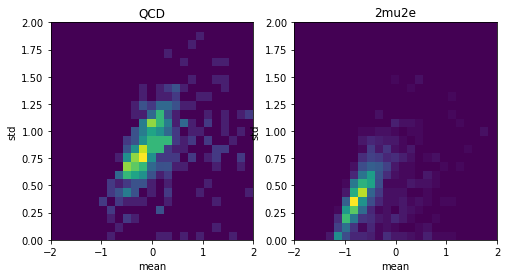

In [43]:
lead2masked0 = mask_leading(mask_leading(partse0))
lead2masked1 = mask_leading(mask_leading(partse1))

fig, axes = plt.subplots(1,2,figsize=(8,4))
axes[0].hist2d(np.log(lead2masked0).mean().flatten(),
               np.log(lead2masked0).std().flatten(),
               range=[[-2,2], [0,2]], bins=(25, 25), density=True)
axes[0].set_title('QCD')
axes[1].hist2d(np.log(lead2masked1).mean().flatten(),
               np.log(lead2masked1).std().flatten(),
               range=[[-2,2], [0,2]], bins=(25, 25), density=True)
axes[1].set_title('2mu2e')
for ax in axes.flat:
    ax.set_xlabel('mean')
    ax.set_ylabel('std')
    ax.set_xlim([-2,2])
    ax.set_ylim([0,2]);

In [34]:
def get_energydist0(f):
    p4 = TLorentzVectorArray.from_ptetaphi(*get_ljparts(f))
    leading = p4[p4.energy.argmax()]
    dist = p4.delta_r(p4.ones_like()*leading.flatten(axis=1))
    loge = np.log(p4.energy)
    val = (loge*dist).sum()/loge.sum()
    return val

def get_energydist1(f):
    p4 = TLorentzVectorArray.from_ptetaphi(*get_ljparts(f))
    leading = p4[p4.energy.argmax()]
    p4 = mask_leading_energy(p4)
    dist = p4.delta_r(p4.ones_like()*leading.flatten(axis=1))
    loge = np.log(p4.energy)
    val = (loge*dist).sum()/loge.sum()
    return val

def get_energydist2(f):
    p4 = TLorentzVectorArray.from_ptetaphi(*get_ljparts(f))
    leading = p4[p4.energy.argmax()]
    p4 = mask_leading_energy(mask_leading_energy(p4))
    dist = p4.delta_r(p4.ones_like()*leading.flatten(axis=1))
    loge = np.log(p4.energy)
    val = (loge*dist).sum()/loge.sum()
    return val

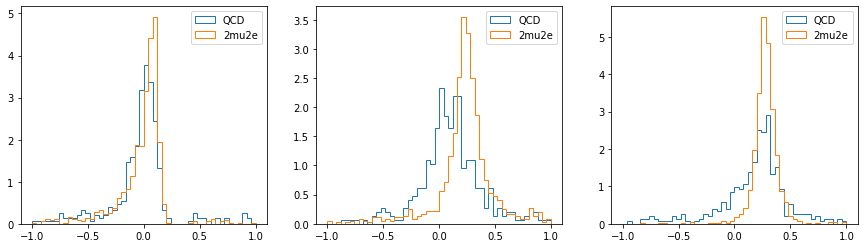

In [36]:
fig, axes = plt.subplots(1,3,figsize=(15,4))
axes[0].hist(get_energydist0(f0).flatten(), bins=50, range=[-1,1], density=True, label='QCD', histtype='step')
axes[0].hist(get_energydist0(f1).flatten(), bins=50, range=[-1,1], density=True, label='2mu2e', histtype='step')
axes[1].hist(get_energydist1(f0).flatten(), bins=50, range=[-1,1], density=True, label='QCD', histtype='step')
axes[1].hist(get_energydist1(f1).flatten(), bins=50, range=[-1,1], density=True, label='2mu2e', histtype='step')
axes[2].hist(get_energydist2(f0).flatten(), bins=50, range=[-1,1], density=True, label='QCD', histtype='step')
axes[2].hist(get_energydist2(f1).flatten(), bins=50, range=[-1,1], density=True, label='2mu2e', histtype='step')

for ax in axes:
    ax.legend()

---

In [73]:
outputstore = {} ## storing the outputs

In [74]:
class JetParticleEnergyProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'dataset')
        logmean_ax = hist.Bin('logmean', 'log(mean)', 40, -2, 2)
        logstd_ax = hist.Bin('logstd', 'log(std)', 40, 0, 2)
        energydist_ax = hist.Bin('edist', 'sum(log(energy)*deltaR)/sum(log(energy))', 40, -1, 1)
        match_axis = hist.Bin('match', 'match',2,0,2)
        
        self._accumulator = processor.dict_accumulator({
            'particleEnergy': hist.Hist('norm. counts', dataset_axis, logmean_ax, logstd_ax, energydist_ax, match_axis)
        })
        
    @property
    def accumulator(self):
        return self._accumulator
    
    def get_energydist1(self, df):
        p4 = TLorentzVectorArray.from_ptetaphi(NestNestObjArrayToJagged(df['pfjet_pfcand_pt']),
                                              NestNestObjArrayToJagged(df['pfjet_pfcand_eta']),
                                              NestNestObjArrayToJagged(df['pfjet_pfcand_phi']),
                                              NestNestObjArrayToJagged(df['pfjet_pfcand_energy']))
        leading = p4[p4.energy.argmax()]
        p4 = mask_leading_energy(p4)
        dist = p4.delta_r(p4.ones_like()*leading.flatten(axis=1))
        loge = np.log(p4.energy)
        val = (loge*dist).sum()/loge.sum()
        return val
        
    def process(self, df):
        output = self.accumulator.identity()
        dataset=df['dataset']
        
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
        )
        genparticles = JaggedCandidateArray.candidatesfromcounts(
            df['gen_p4'],
            px=df['gen_p4.fCoordinates.fX'],
            py=df['gen_p4.fCoordinates.fY'],
            pz=df['gen_p4.fCoordinates.fZ'],
            energy=df['gen_p4.fCoordinates.fT'],
            pid=df['gen_pid']
        )
        darkphotons = genparticles[genparticles.pid==32]
        matchmask = leptonjets.match(darkphotons, deltaRCut=0.3)
        ljpart_energy = NestNestObjArrayToJagged(df['pfjet_pfcand_energy'])
        lead2masked = mask_leading(mask_leading(ljpart_energy))
        
        
        energydist = self.get_energydist1(df)
        
        output['particleEnergy'].fill(dataset=dataset,
                                     logmean=np.log(lead2masked).mean().flatten(),
                                     logstd=np.log(lead2masked).std().flatten(),
                                     edist=energydist.flatten(),
                                     match=matchmask.astype(int).flatten())
        return output
    
    def postprocess(self, accumulator):
        return accumulator

### lxy: 0.3cm

In [75]:
dataset={
    '4mu/mXX-100_mA-5_lxy-0p3': dataset4mu_['mXX-100_mA-5_lxy-0p3'],
    '4mu/mXX-1000_mA-0p25_lxy-0p3': dataset4mu_['mXX-1000_mA-0p25_lxy-0p3'],
    '2mu2e/mXX-100_mA-5_lxy-0p3': dataset2mu2e_['mXX-100_mA-5_lxy-0p3'],
    '2mu2e/mXX-1000_mA-0p25_lxy-0p3': dataset2mu2e_['mXX-1000_mA-0p25_lxy-0p3'],
}

output = processor.run_uproot_job(dataset,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=JetParticleEnergyProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )
outputstore['signal-0p3'] = output['particleEnergy']

Processing: 100%|██████████| 20/20 [00:06<00:00,  3.31items/s]


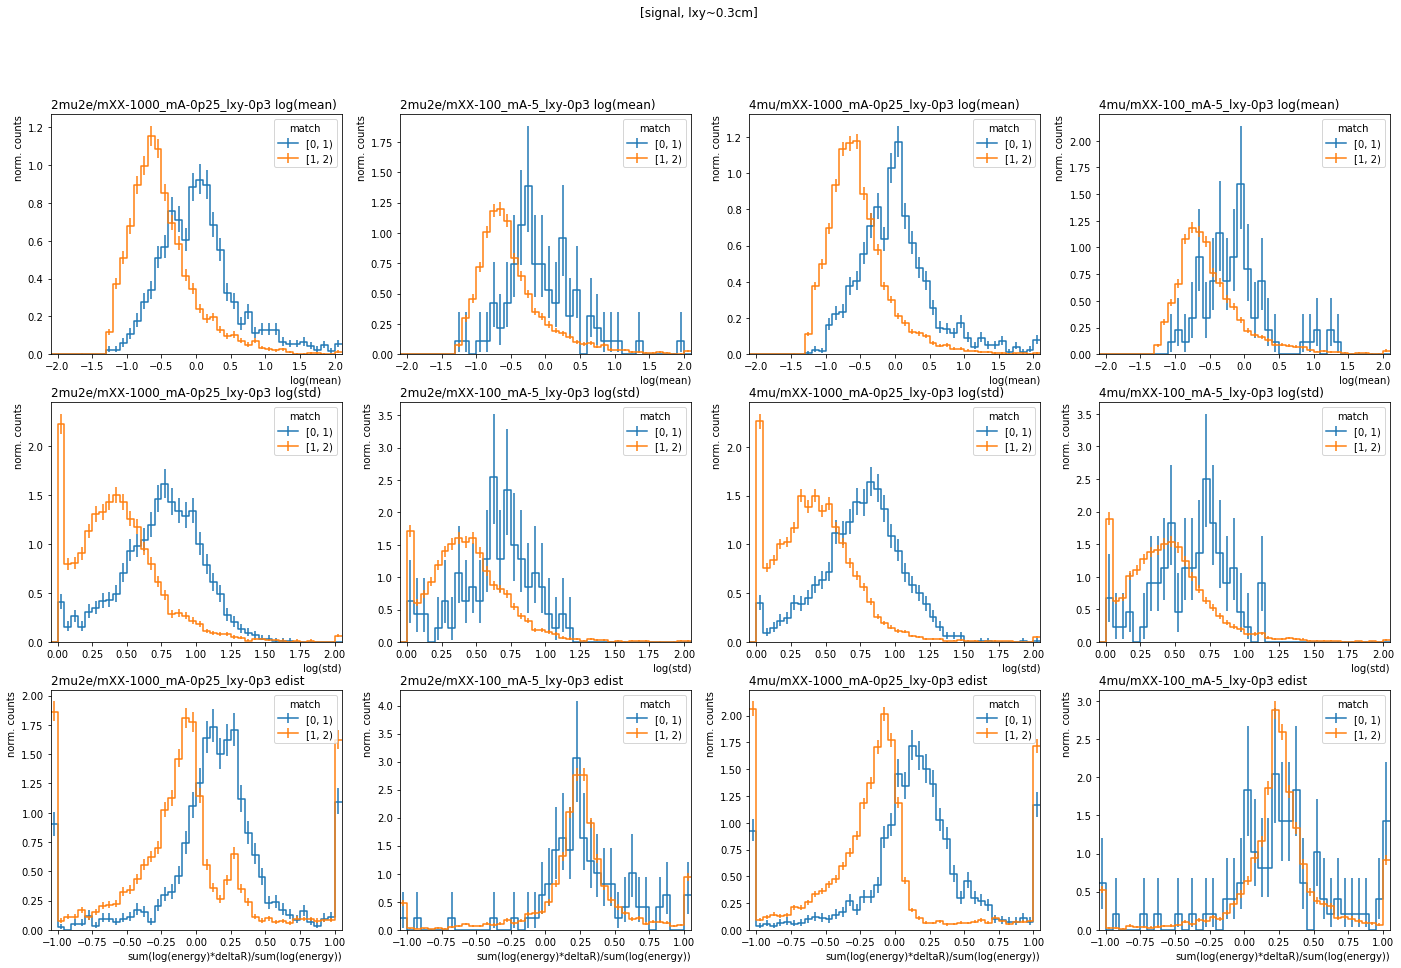

In [59]:
dsids = output['particleEnergy'].identifiers('dataset')

fig, axes = plt.subplots(3,4,figsize=(24,15))
for i, ds in enumerate(dsids):
    hist.plot1d(output['particleEnergy'].project('dataset', ds).project('logstd').project('edist'),
                overlay='match', density=True, ax=axes[0][i], overflow='all')
    hist.plot1d(output['particleEnergy'].project('dataset', ds).project('logmean').project('edist'),
                overlay='match', density=True, ax=axes[1][i], overflow='all')
    hist.plot1d(output['particleEnergy'].project('dataset', ds).project('logstd').project('logmean'),
                overlay='match', density=True, ax=axes[2][i], overflow='all')
    axes[0][i].set_title(str(ds)+' log(mean)', x=0, ha='left')
    axes[1][i].set_title(str(ds)+' log(std)', x=0, ha='left')
    axes[2][i].set_title(str(ds)+' edist', x=0, ha='left')
for ax in axes.flat:
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
plt.suptitle('[signal, lxy~0.3cm]');

### lxy: 300cm

In [76]:
dataset={
    '4mu/mXX-100_mA-5_lxy-300': dataset4mu_['mXX-100_mA-5_lxy-300'],
    '4mu/mXX-1000_mA-0p25_lxy-300': dataset4mu_['mXX-1000_mA-0p25_lxy-300'],
    '2mu2e/mXX-100_mA-5_lxy-300': dataset2mu2e_['mXX-100_mA-5_lxy-300'],
    '2mu2e/mXX-1000_mA-0p25_lxy-300': dataset2mu2e_['mXX-1000_mA-0p25_lxy-300'],
}

output = processor.run_uproot_job(dataset,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=JetParticleEnergyProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )
outputstore['signal-300'] = output['particleEnergy']

Processing: 100%|██████████| 20/20 [00:08<00:00,  1.39items/s]


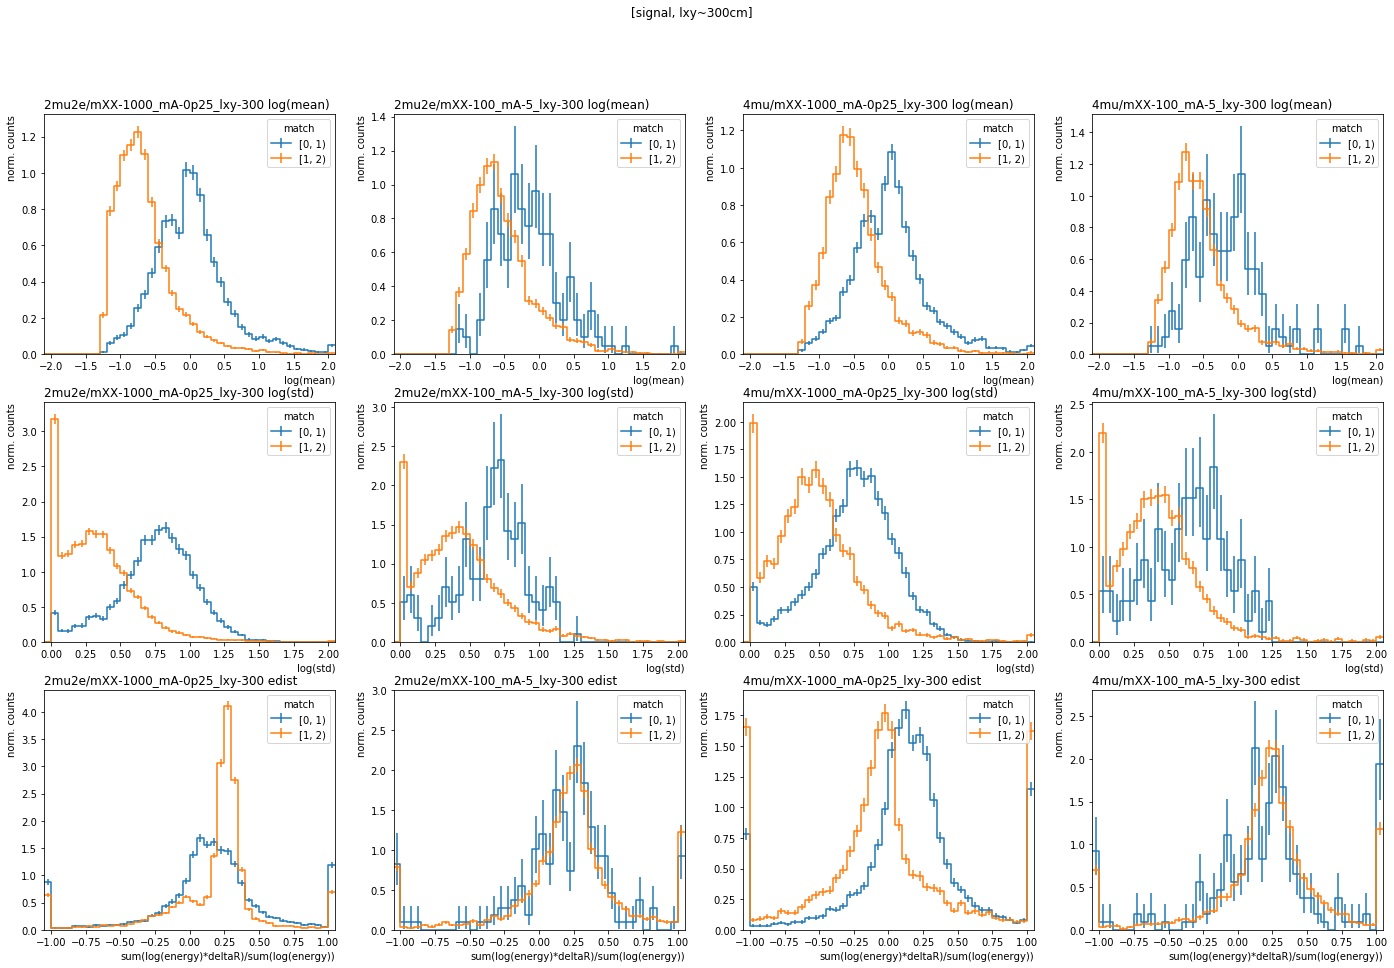

In [57]:
dsids = output['particleEnergy'].identifiers('dataset')

fig, axes = plt.subplots(3,4,figsize=(24,15))
for i, ds in enumerate(dsids):
    hist.plot1d(output['particleEnergy'].project('dataset', ds).project('logstd').project('edist'),
                overlay='match', density=True, ax=axes[0][i], overflow='all')
    hist.plot1d(output['particleEnergy'].project('dataset', ds).project('logmean').project('edist'),
                overlay='match', density=True, ax=axes[1][i], overflow='all')
    hist.plot1d(output['particleEnergy'].project('dataset', ds).project('logstd').project('logmean'),
                overlay='match', density=True, ax=axes[2][i], overflow='all')
    axes[0][i].set_title(str(ds)+' log(mean)', x=0, ha='left')
    axes[1][i].set_title(str(ds)+' log(std)', x=0, ha='left')
    axes[2][i].set_title(str(ds)+' edist', x=0, ha='left')
for ax in axes.flat:
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
plt.suptitle('[signal, lxy~300cm]');

### background events: QCD, DYJets, TTJets

In [77]:
class JetParticleEnergyProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'dataset')
        logmean_ax = hist.Bin('logmean', 'log(mean)', 40, -2, 2)
        logstd_ax = hist.Bin('logstd', 'log(std)', 40, 0, 2)
        energydist_ax = hist.Bin('edist', 'sum(log(energy)*deltaR)/sum(log(energy))', 40, -1, 1)
        
        self._accumulator = processor.dict_accumulator({
            'particleEnergy': hist.Hist('norm. counts', dataset_axis, logmean_ax, logstd_ax, energydist_ax)
        })
        
    @property
    def accumulator(self):
        return self._accumulator
    
    def get_energydist1(self, df):
        p4 = TLorentzVectorArray.from_ptetaphi(NestNestObjArrayToJagged(df['pfjet_pfcand_pt']),
                                              NestNestObjArrayToJagged(df['pfjet_pfcand_eta']),
                                              NestNestObjArrayToJagged(df['pfjet_pfcand_phi']),
                                              NestNestObjArrayToJagged(df['pfjet_pfcand_energy']))
        leading = p4[p4.energy.argmax()]
        p4 = mask_leading_energy(p4)
        dist = p4.delta_r(p4.ones_like()*leading.flatten(axis=1))
        loge = np.log(p4.energy)
        val = (loge*dist).sum()/loge.sum()
        return val
        
    def process(self, df):
        output = self.accumulator.identity()
        dataset=df['dataset']
        
        ljpart_energy = NestNestObjArrayToJagged(df['pfjet_pfcand_energy'])
        lead2masked = mask_leading(mask_leading(ljpart_energy))
        
        
        energydist = self.get_energydist1(df)
        
        output['particleEnergy'].fill(dataset=dataset,
                                     logmean=np.log(lead2masked).mean().flatten(),
                                     logstd=np.log(lead2masked).std().flatten(),
                                     edist=energydist.flatten())
        return output
    
    def postprocess(self, accumulator):
        return accumulator

In [78]:
dataset = {
    'TTJets_DiLept': bkgdatasets_['TTJets']['TTJets_DiLept'],
    'DYJets': bkgdatasets_['DYJetsToLL']['DYJetsToLL-M-10to50']+bkgdatasets_['DYJetsToLL']['DYJetsToLL_M-50']
}
output = processor.run_uproot_job(dataset,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=JetParticleEnergyProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )
outputstore['bkg1'] = output['particleEnergy']

Processing: 100%|██████████| 1529/1529 [04:58<00:00,  6.93items/s]


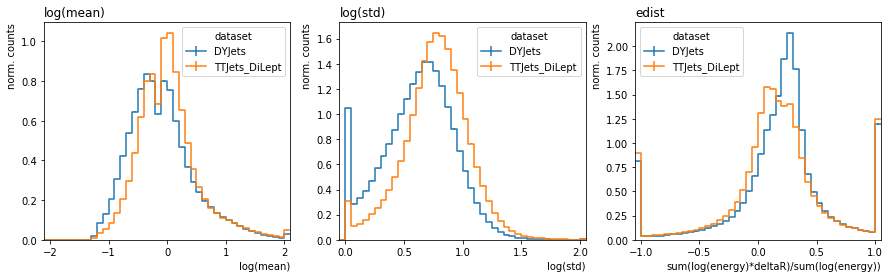

In [65]:
fig, axes = plt.subplots(1,3,figsize=(15,4))
hist.plot1d(output['particleEnergy'].project('logstd').project('edist'),
            overlay='dataset', density=True, ax=axes[0], overflow='all')
hist.plot1d(output['particleEnergy'].project('logmean').project('edist'),
            overlay='dataset', density=True, ax=axes[1], overflow='all')
hist.plot1d(output['particleEnergy'].project('logstd').project('logmean'),
            overlay='dataset', density=True, ax=axes[2], overflow='all')
axes[0].set_title('log(mean)', x=0, ha='left')
axes[1].set_title('log(std)', x=0, ha='left')
axes[2].set_title('edist', x=0, ha='left')
for ax in axes.flat:
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")

In [79]:
dataset = bkgdatasets_['QCD']
output = processor.run_uproot_job(dataset,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=JetParticleEnergyProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )
outputstore['bkg2'] = output['particleEnergy']

Processing: 100%|██████████| 1256/1256 [05:36<00:00,  1.32items/s]


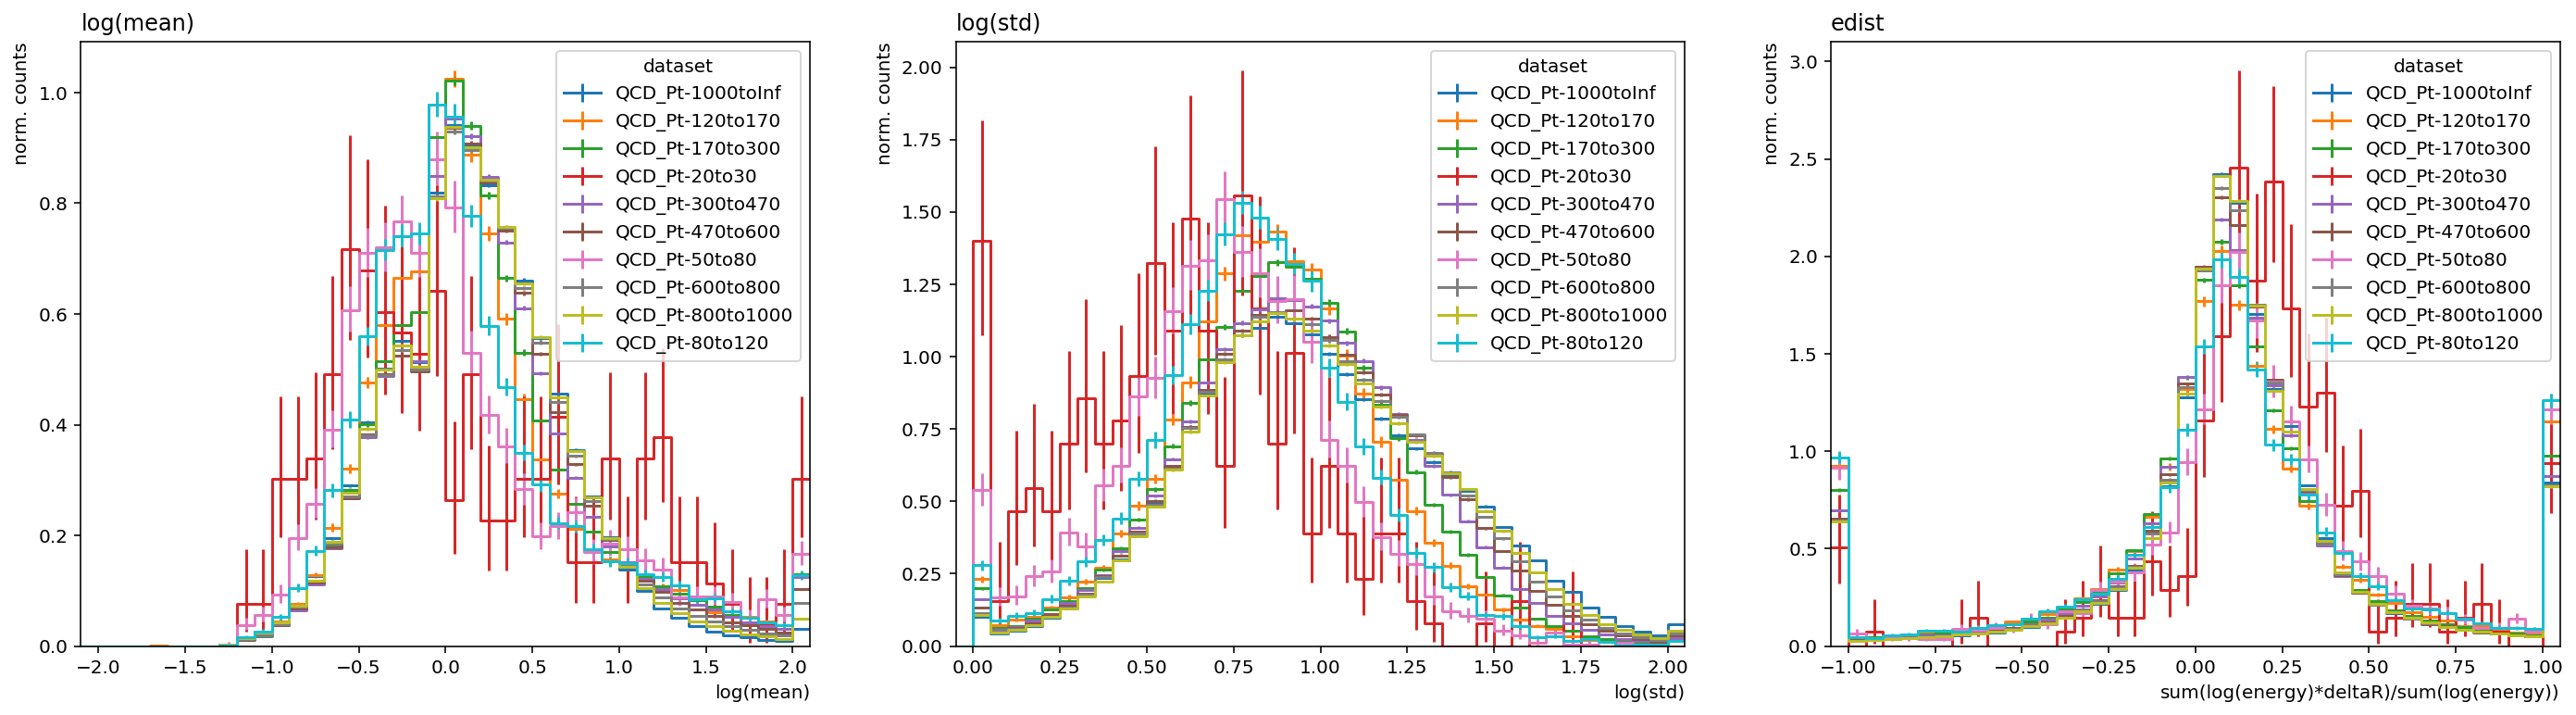

In [70]:
fig, axes = plt.subplots(1,3,figsize=(24,6))
hist.plot1d(output['particleEnergy'].project('logstd').project('edist'),
            overlay='dataset', density=True, ax=axes[0], overflow='all')
hist.plot1d(output['particleEnergy'].project('logmean').project('edist'),
            overlay='dataset', density=True, ax=axes[1], overflow='all')
hist.plot1d(output['particleEnergy'].project('logstd').project('logmean'),
            overlay='dataset', density=True, ax=axes[2], overflow='all')
axes[0].set_title('log(mean)', x=0, ha='left')
axes[1].set_title('log(std)', x=0, ha='left')
axes[2].set_title('edist', x=0, ha='left')
for ax in axes.flat:
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")

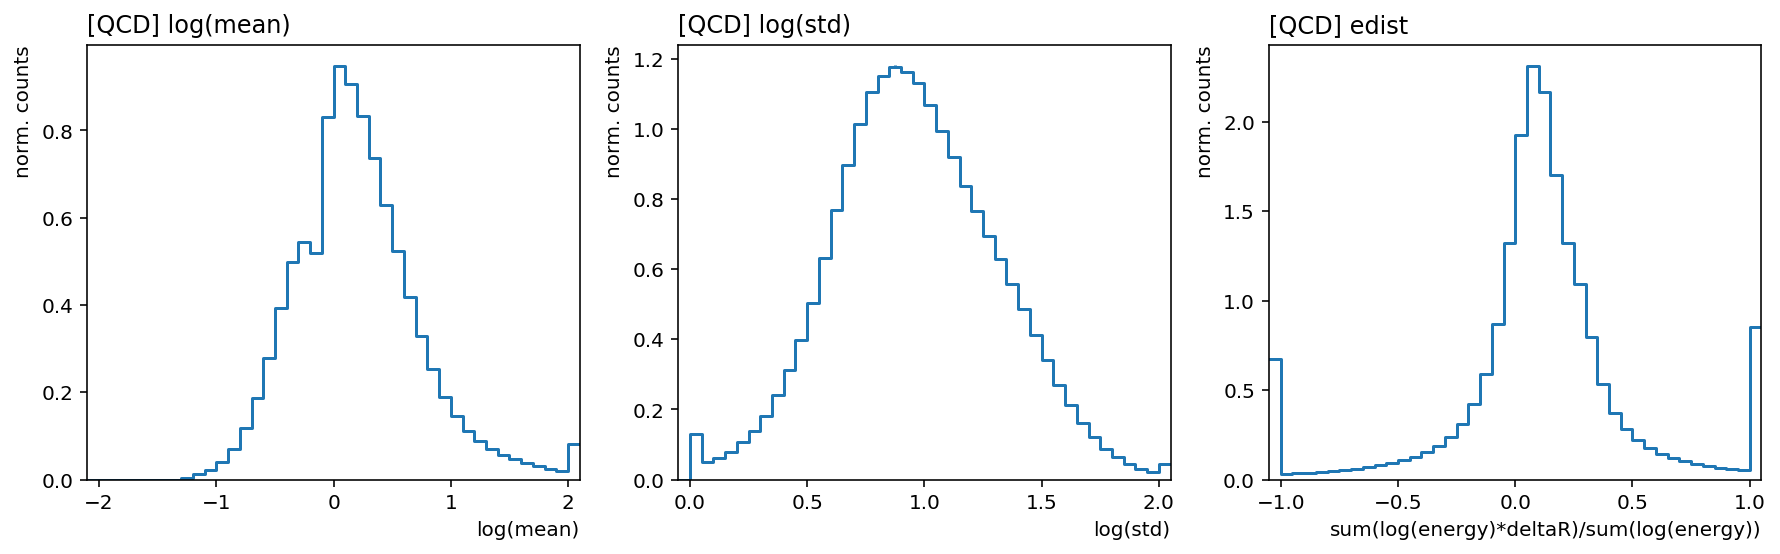

In [72]:
fig, axes = plt.subplots(1,3,figsize=(15,4))
hist.plot1d(output['particleEnergy'].project('dataset').project('logstd').project('edist'),
            density=True, ax=axes[0], overflow='all')
hist.plot1d(output['particleEnergy'].project('dataset').project('logmean').project('edist'),
            density=True, ax=axes[1], overflow='all')
hist.plot1d(output['particleEnergy'].project('dataset').project('logstd').project('logmean'),
            density=True, ax=axes[2], overflow='all')
axes[0].set_title('[QCD] log(mean)', x=0, ha='left')
axes[1].set_title('[QCD] log(std)', x=0, ha='left')
axes[2].set_title('[QCD] edist', x=0, ha='left')
for ax in axes.flat:
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")

overlay some signal and backgrouds into a single plot

In [81]:
outputstore

{'signal-0p3': <Hist (dataset,logmean,logstd,edist,match) instance at 0x7f748034ceb8>,
 'signal-300': <Hist (dataset,logmean,logstd,edist,match) instance at 0x7f748034cb00>,
 'bkg1': <Hist (dataset,logmean,logstd,edist) instance at 0x7f748b2d9be0>,
 'bkg2': <Hist (dataset,logmean,logstd,edist) instance at 0x7f7457ee45f8>}

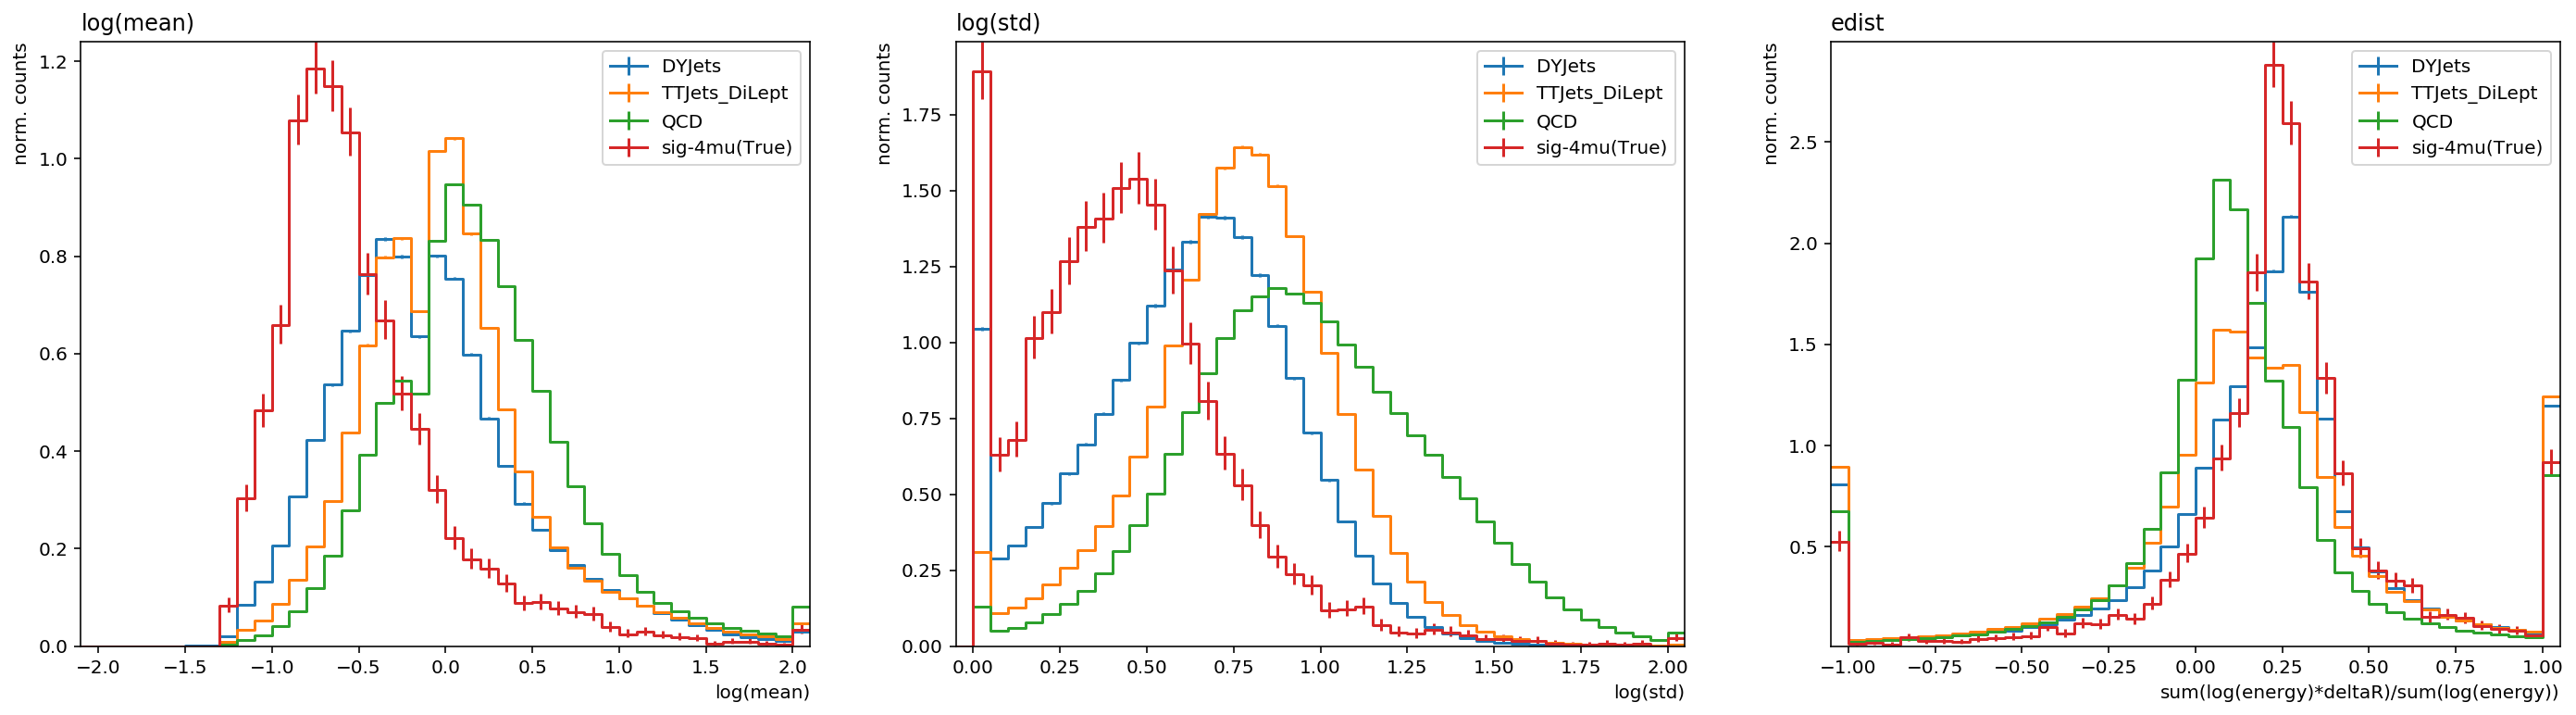

In [113]:
fig, axes = plt.subplots(1,3,figsize=(24,6))

handles, labels = [], []
_, _, prim = hist.plot1d(outputstore['bkg1'].project('logstd').project('edist'), overlay='dataset', density=True, ax=axes[0], overflow='all')
_, _, prim = hist.plot1d(outputstore['bkg1'].project('logmean').project('edist'), overlay='dataset', density=True, ax=axes[1], overflow='all')
_, _, prim = hist.plot1d(outputstore['bkg1'].project('logmean').project('logstd'), overlay='dataset', density=True, ax=axes[2], overflow='all')
for k, v in prim.items():
    if not isinstance(v, list): continue
    handles.append(tuple(v))
    labels.append(str(k))
    
_, _, prim = hist.plot1d(outputstore['bkg2'].project('dataset').project('logstd').project('edist'), density=True, ax=axes[0], overflow='all', clear=False)
_, _, prim = hist.plot1d(outputstore['bkg2'].project('dataset').project('logmean').project('edist'), density=True, ax=axes[1], overflow='all', clear=False)
_, _, prim = hist.plot1d(outputstore['bkg2'].project('dataset').project('logmean').project('logstd'), density=True, ax=axes[2], overflow='all', clear=False)
handles.append(tuple(prim[None]))
labels.append('QCD')

_, _, prim = hist.plot1d(outputstore['signal-0p3'].project('logstd').project('edist').project('dataset','4mu/mXX-100_mA-5_lxy-0p3').project('match', hist.hist_tools.Interval(1,2)),
             density=True, ax=axes[0], overflow='all', clear=False)
_, _, prim = hist.plot1d(outputstore['signal-0p3'].project('logmean').project('edist').project('dataset','4mu/mXX-100_mA-5_lxy-0p3').project('match', hist.hist_tools.Interval(1,2)),
             density=True, ax=axes[1], overflow='all', clear=False)
_, _, prim = hist.plot1d(outputstore['signal-0p3'].project('logmean').project('logstd').project('dataset','4mu/mXX-100_mA-5_lxy-0p3').project('match', hist.hist_tools.Interval(1,2)),
             density=True, ax=axes[2], overflow='all', clear=False)
handles.append(tuple(prim[None]))
labels.append('sig-4mu(True)')


axes[0].set_title('log(mean)', x=0, ha='left')
axes[1].set_title('log(std)', x=0, ha='left')
axes[2].set_title('edist', x=0, ha='left')
for ax in axes.flat:
    ax.legend(handles, labels)
    ax.autoscale(axis='y', tight=True)
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")